In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot  as plt
from matplotlib.pyplot import imshow,imread
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,ID,Male,Boneage,Zscore
0,1377.png,0,180,1.279181
1,1378.png,0,12,-2.800269
2,1379.png,0,94,-0.809109
3,1380.png,1,120,-0.177766
4,1381.png,0,82,-1.100498
...,...,...,...,...
12606,15605.png,0,50,-1.877537
12607,15606.png,0,113,-0.347743
12608,15608.png,0,55,-1.756124
12609,15609.png,1,150,0.550708


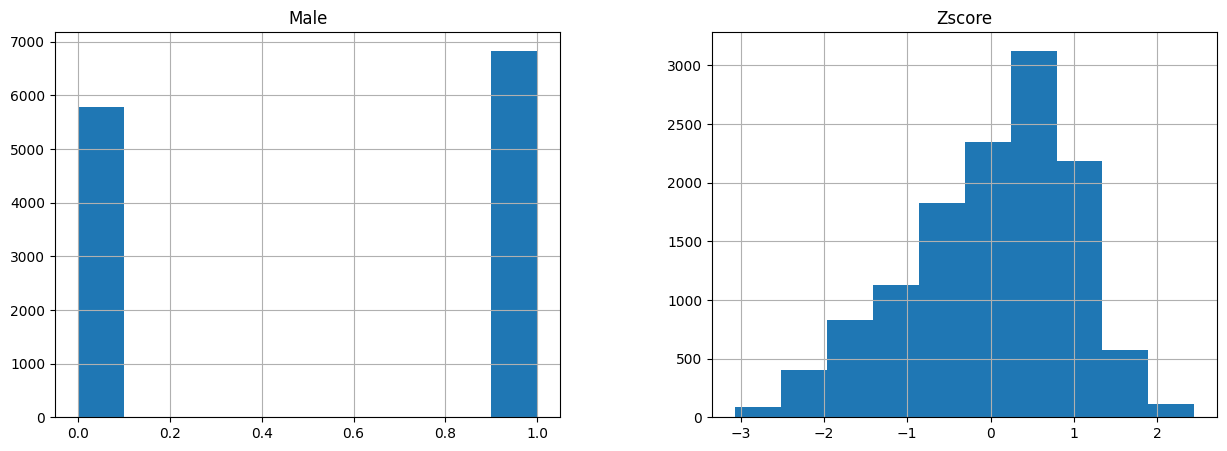

In [2]:
data_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv')
data_df ['ID'] = data_df['ID'].map(lambda x: f'{x}.png')
data_df['Male']= data_df['Male'].map(lambda x: 1 if (x == True) else 0)
mean = data_df['Boneage'].mean()
stdd = data_df['Boneage'].std()
data_df['Zscore']= data_df['Boneage'].map(lambda x:(x-mean)/stdd)
data_df[['Male','Zscore']].hist(figsize=(15,5))
data_df

In [3]:
test_df = pd.read_csv('dataset/RSNA_Annotations/RSNA_Annotations/BONEAGE/gender_test.csv')
test_df['ID'] = test_df['ID'].map(lambda x: f'{x}.png')

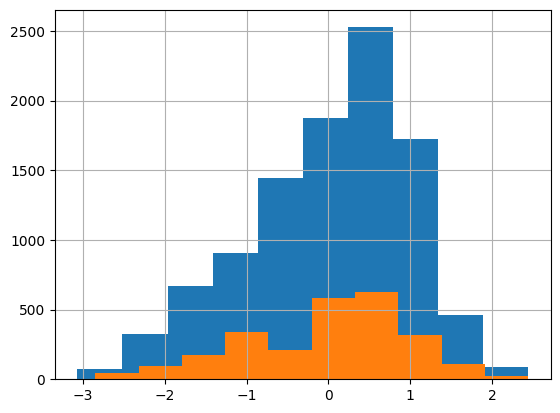

In [4]:
train_df = data_df.sample(frac=0.8)
valid_df = data_df.drop(train_df.index)


ax = [train_df['Zscore'].hist() ,valid_df['Zscore'].hist()]

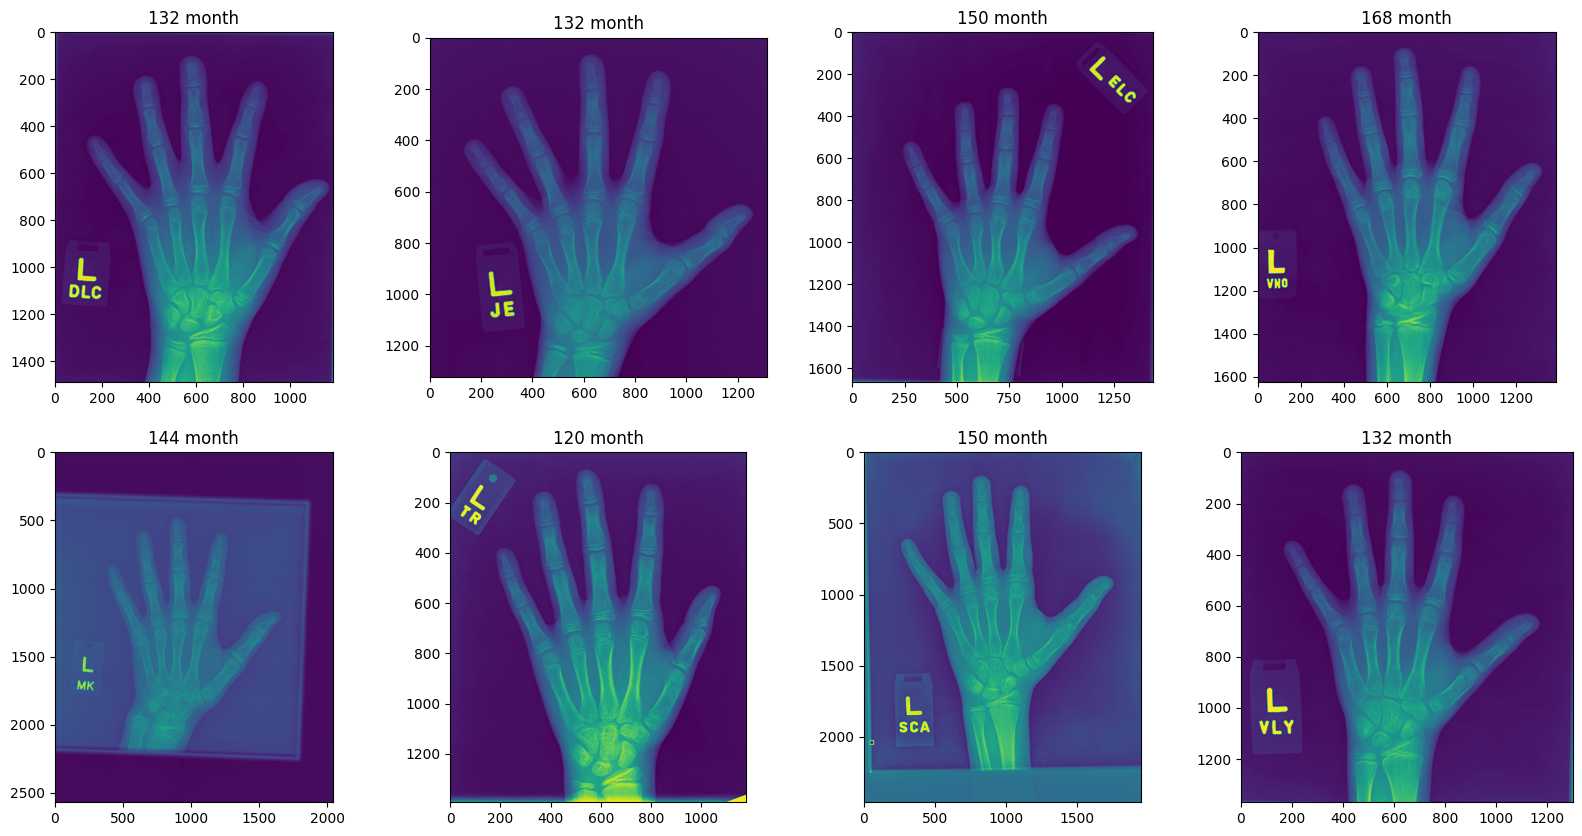

In [5]:
train_dir='dataset/RSNA_train/images'
test_dir= 'dataset/RSNA_test/images'
sample = data_df.sample(n=8)
fig,axx = plt.subplots(2,4, figsize=(20,10))
for idd,boneage,place in zip(sample['ID'],sample['Boneage'],axx.flatten()):
    place.imshow(imread(f"{train_dir}/{idd}"))
    place.set_title(str(boneage)+' month')

In [6]:
core_dg = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    dtype=None,
    preprocessing_function = tf.keras.applications.xception.preprocess_input
)

In [7]:
train_dg = core_dg.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="ID",
    y_col="Zscore",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 10089 validated image filenames.


In [8]:
valid_dg = core_dg.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col="ID",
    y_col="Zscore",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="raw",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 2522 validated image filenames.


In [9]:
test_dg_core = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
test_dg = test_dg_core.flow_from_dataframe(test_df,
                                          x_col='ID',
                                          directory = test_dir,
                                          class_mode = None)

Found 200 validated image filenames.


In [10]:
from keras import Sequential
from keras.layers import Dense,GlobalMaxPooling2D
from keras.applications.xception import Xception
from keras.metrics import MeanAbsoluteError
model_base = Xception(include_top = False,input_shape=(256,256,3))
model_base.trainable = True

In [11]:
model = None
model = Sequential()
model.add(model_base)
model.add(GlobalMaxPooling2D())
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mse', optimizer= 'adam', metrics=[MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,881,981
Trainable params: 20,827,453
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
model.fit_generator(train_dg,
                            validation_data = valid_dg,
                            validation_steps = 1,
                            epochs = 2
                            )

C:\Users\prkna\AppData\Local\Temp\ipykernel_17040\4239237332.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_dg,


Epoch 1/2
  6/316 [..............................] - ETA: 1:36:56 - loss: 3.8362 - mean_absolute_error: 1.4784

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/xception/block9_sepconv3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1899, in _run_once
      handle._run()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\prkna\AppData\Local\Temp\ipykernel_17040\4239237332.py", line 1, in <module>
      model.fit_generator(train_dg,
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2507, in fit_generator
      return self.fit(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\prkna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/xception/block9_sepconv3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,728,16,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node sequential/xception/block9_sepconv3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11651]

In [12]:
model.fit_generator(train_dg,
                            steps_per_epoch = 315,
                            validation_data = valid_dg,
                            validation_steps = 1,
                            epochs = 20
                            )

Epoch 1/20
315/315 [==============================] - 655s 2s/step - loss: 0.3979 - mean_absolute_error: 0.4846 - val_loss: 0.2087 - val_mean_absolute_error: 0.3819
Epoch 2/20
315/315 [==============================] - 582s 2s/step - loss: 0.2010 - mean_absolute_error: 0.3551 - val_loss: 0.4312 - val_mean_absolute_error: 0.5197
Epoch 3/20
315/315 [==============================] - 568s 2s/step - loss: 0.1773 - mean_absolute_error: 0.3335 - val_loss: 0.1793 - val_mean_absolute_error: 0.3560
Epoch 4/20
315/315 [==============================] - 553s 2s/step - loss: 0.1563 - mean_absolute_error: 0.3131 - val_loss: 0.4715 - val_mean_absolute_error: 0.6129
Epoch 5/20
315/315 [==============================] - 564s 2s/step - loss: 0.1436 - mean_absolute_error: 0.3000 - val_loss: 0.1971 - val_mean_absolute_error: 0.3443
Epoch 6/20
315/315 [==============================] - 574s 2s/step - loss: 0.1364 - mean_absolute_error: 0.2909 - val_loss: 0.1886 - val_mean_absolute_error: 0.3495
Epoch 7/20

In [13]:
model.save('/kaggle/working/output')
